In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

df = pd.read_csv("petfinder-mini.csv")
df.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [2]:
# In the original dataset, `'AdoptionSpeed'` of `4` indicates a pet was not adopted.
df['target'] = np.where(df['AdoptionSpeed']==4, 0, 1)

# Drop unused features.
df = df.drop(columns=['AdoptionSpeed', 'Description'])

In [10]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ["target"])
y = df["target"]


In [11]:
def get_normalization_layer(columna, dataset): #NORMALIZAR DATOS NUMERICOS
    index = layers.Normalization()
    index.adapt(dataset[columna].to_numpy().reshape(-1, 1))
    return index(dataset[columna]).numpy().flatten()

def get_category_encoding_layer(columna, dataset): #One hot a datos categoricos (numericos y cualitativos)
    if columna in (df.select_dtypes(include = np.number).columns):
        index = layers.IntegerLookup(max_tokens = 5) # Max define que tomara los n-1 valores mas frecuentes y los demas seran OOV (Out Of Vocabulary)
        index.adapt(dataset[columna])
        indices = index(dataset[columna])
    
    else:  
        index = layers.StringLookup()
        index.adapt(dataset[columna])
        indices = index(dataset[columna])
    
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode="one_hot")
    aux = pd.DataFrame(encoder(indices), columns = index.get_vocabulary()).rename(columns = {-1 : "OOV"})
    return aux



In [12]:
numericas = ["PhotoAmt","Fee"]
categoricos = X.columns.drop(numericas)
categoricos

Index(['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize',
       'FurLength', 'Vaccinated', 'Sterilized', 'Health'],
      dtype='object')

In [13]:
for column in numericas:
    X[column] = get_normalization_layer(column, X.copy())


In [14]:
for column in categoricos:
    aux = get_category_encoding_layer(column, X)
    X = pd.concat([X, aux], axis=1)
    X.drop(column, axis = 1, inplace = True)
X.columns

Index([           'Fee',       'PhotoAmt',          '[UNK]',            'Dog',
                  'Cat',            'OOV',                2,                3,
                      1,                4,
       ...
                   'No',       'Not Sure',          '[UNK]',             'No',
                  'Yes',       'Not Sure',          '[UNK]',        'Healthy',
         'Minor Injury', 'Serious Injury'],
      dtype='object', length=216)

In [15]:
X.head()

,Fee,PhotoAmt,[UNK],Dog,Cat,OOV,2,3,1,4,...,No,Not Sure,[UNK],No,Yes,Not Sure,[UNK],Healthy,Minor Injury,Serious Injury
0,0.950288,-0.829762,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.299388,-0.511871,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.299388,1.077582,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.575125,1.395473,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.299388,-0.193980,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [73]:
from tensorflow.keras.layers import Dropout, Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2




early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=666 )
model = Sequential()
model.add(Input(shape=(216,)))
model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu", kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu", kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu", kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer=Adam(learning_rate=.002), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train, 
    y_train, 
    epochs=150, 
    batch_size=4000, 
    verbose=1, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
    )

Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.5075 - loss: 1.0806 - val_accuracy: 0.7097 - val_loss: 0.8810
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5342 - loss: 1.0027 - val_accuracy: 0.7257 - val_loss: 0.8663
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5564 - loss: 0.9367 - val_accuracy: 0.7296 - val_loss: 0.8534
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5802 - loss: 0.9019 - val_accuracy: 0.7318 - val_loss: 0.8419
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5905 - loss: 0.8716 - val_accuracy: 0.7318 - val_loss: 0.8306
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6008 - loss: 0.8496 - val_accuracy: 0.7318 - val_loss: 0.8196
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6231 - loss: 0.8273 - val_accuracy: 0.7318 - val_loss: 0.8084
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6462 - loss: 0.8065 - val_accuracy: 0.7318 - val_loss

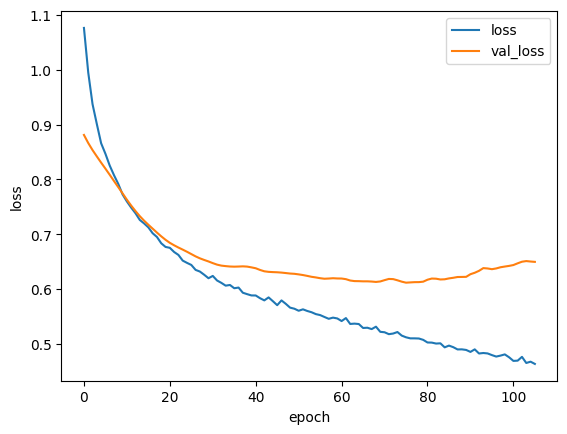

In [74]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [75]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy en test: {accuracy:.4f}')

Accuracy en test: 0.7318


In [76]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Accuracy en train: {train_accuracy:.4f}')

Accuracy en train: 0.7333


In [77]:
model.predict(X_test)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[0.8236293 ],
       [0.8163688 ],
       [0.7457702 ],
       ...,
       [0.81154907],
       [0.7659782 ],
       [0.77294433]], dtype=float32)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


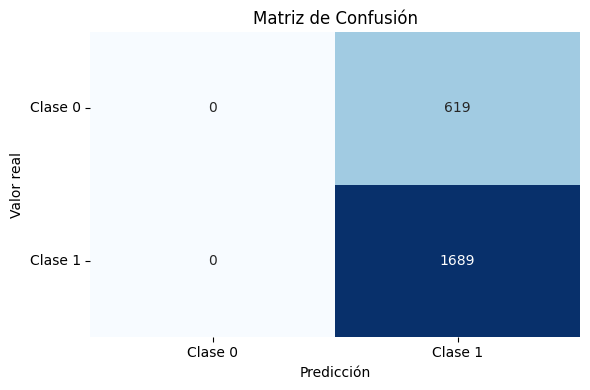

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obtener las predicciones
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.xticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.yticks([0.5, 1.5], ['Clase 0', 'Clase 1'], rotation=0)
plt.tight_layout()
plt.show()

In [80]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Obtener las predicciones del modelo
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)  # convertir probabilidades a etiquetas (umbral 0.5)

# Métricas detalladas
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# También puedes imprimirlas individualmente si lo prefieres:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       619
           1       0.73      1.00      0.85      1689

    accuracy                           0.73      2308
   macro avg       0.37      0.50      0.42      2308
weighted avg       0.54      0.73      0.62      2308

Accuracy: 0.7318
Precision: 0.7318
Recall: 1.0000
F1-score: 0.8451


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
